In [1]:
import wget
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

from restricted_boltzmann import RestrictedBoltzmann
from zipfile import ZipFile

In [ ]:
url = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
filename = wget.download(url)

with ZipFile("ml-1m.zip", "r") as zObject:
    zObject.extractall()

In [2]:
movies_df = pd.read_csv(
    "ml-1m/movies.dat", sep="::", header=None, engine="python", encoding="latin_1"
)
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# loading in the ratings dataset
ratings_df = pd.read_csv("ml-1m/ratings.dat", sep="::", header=None, engine="python")
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies_df.columns = ["MovieID", "Title", "Genres"]
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
user_rating_df = ratings_df.pivot(index="UserID", columns="MovieID", values="Rating")
user_rating_df.head()  # 5 rows x 3706 columns
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
norm_user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


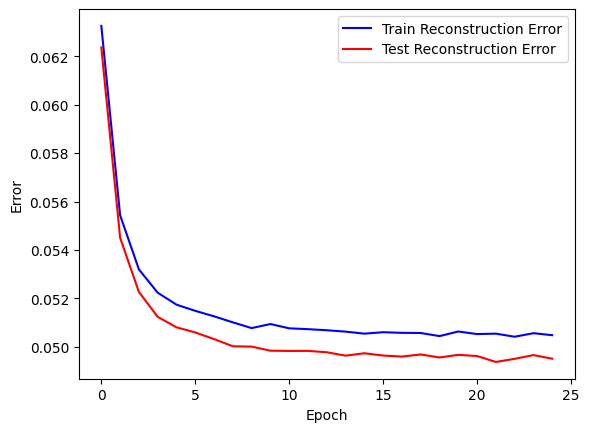

In [7]:
hidden_units = 10
visible_units = len(user_rating_df.columns)
alpha = 1

model = RestrictedBoltzmann()
model.train(trX, hidden_units, visible_units, alpha=1.0, epochs=25, batch_size=100, plot=True)

In [8]:
mock_user_id = 215
input_user = trX[mock_user_id - 1].reshape(1, -1)
input_user[0:5]

array([[0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [9]:
output_user = model.predict_proba(input_user)
output_user[0:5]

array([[0.29731953, 0.0697789 , 0.0469747 , ..., 0.00624257, 0.0057084 ,
        0.04030758]], dtype=float32)

In [10]:
threshold = 0.25
movies_id = list(np.where(output_user[0, :] > threshold)[0])
movies_recomendation = np.where(output_user[0, :] >= np.mean(output_user[0, movies_id]))[0]
print(movies_recomendation)

[ 253  466  513  575  579  593  802 1106 1107 1108 1120 1178 1449 1848
 2203 2374 2557 2651]


In [11]:
model_checkpoint = "model/ml-rbm"
model.save_model(model_checkpoint)

In [12]:
model = RestrictedBoltzmann()
model.load_model(model_checkpoint, hidden_units=hidden_units, visible_units=visible_units)

In [13]:
output_user = model.predict_proba(input_user)
output_user[0:5]

array([[0.29731953, 0.0697789 , 0.0469747 , ..., 0.00624257, 0.0057084 ,
        0.04030758]], dtype=float32)